# P08 — Análisis de Productos de Combustión

Este cuaderno guía todo el flujo de trabajo de la práctica P08:
- Carga y normalización de datos de gases (O2, CO2, CO, NOx, T, P)
- Cálculo de métricas de combustión (λ, φ, AFR, fracciones secas)
- Análisis descriptivo y detección de picos
- Estimación simplificada de temperatura adiabática
- Visualizaciones y exportación de resultados

Los resultados (CSV, PNG, SVG) se guardan en `Practicas/P08_Productos_Combustion/data/` y `.../data/figures/`.

## Fundamentos y ecuaciones

### Estequiometría para $\text{C}_x\text{H}_y$
Reacción (en aire, seco, sin exceso):\
$\$\
$$\text{C}_x\text{H}_y + \left(x + \tfrac{y}{4}\right) (\text{O}_2 + 3.7619\,\text{N}_2) \; \to \; x\,\text{CO}_2 + \tfrac{y}{2}\,\text{H}_2\text{O} + 3.7619\left(x + \tfrac{y}{4}\right)\,\text{N}_2$$

- Requerimiento molar de oxígeno: $\, \nu_{O_2} = x + \tfrac{y}{4}$.
- Gases secos a la salida (estequiométrico): $\text{CO}_2$ y $\text{N}_2$.
- Fracción seca de $\text{CO}_2$ a estequiometría (sin exceso):\
$$y_{\text{CO}_2,\,\text{dry,st}} = \frac{x}{\,x + 3.7619\left(x + \tfrac{y}{4}\right)\,}$$

### Razón aire/combustible (AFR), exceso de aire ($\lambda$) y relación de equivalencia ($\varphi$)
- AFR estequiométrica (base masa) puede estimarse con:\
$$\text{AFR}_{st} = \frac{m_{\text{aire,st}}}{m_{\text{comb}}} = \frac{\left[\nu_{O_2}\,M_{O_2} + 3.7619\,\nu_{O_2}\,M_{N_2}\right]}{x\,M_C + y\,M_H}$$
donde $M_{O_2} \approx 32$, $M_{N_2} \approx 28.97$, $M_C \approx 12.011$, $M_H \approx 1.008$ (g/mol).

- Exceso de aire: $\; \lambda = \dfrac{\text{AFR}_{act}}{\text{AFR}_{st}}$.\
- Relación de equivalencia: $\; \varphi = \dfrac{1}{\lambda}$.

### Estimación de $\lambda$ a partir de gases secos (O2/CO2)
Una aproximación útil en combustión con aire:\
$$\lambda \approx \left( \frac{\text{CO}_{2,\,\text{st,dry}}}{\text{CO}_{2,\,\text{med}}} \right) \cdot \left( \frac{21}{21 - \text{O}_{2,\,\text{med}}} \right)$$
donde las concentraciones de O2 y CO2 medidas se expresan en % en base seca, y $\text{CO}_{2,\,\text{st,dry}}$ depende de $(x,y)$ del combustible.

### Temperatura adiabática (estimación simplificada)
Suponiendo calores específicos promedio aproximadamente constantes en el rango de interés, puede aproximarse:\
$$T_{ad} \approx T_0 + \frac{\text{LHV}}{\sum_i n_i c_{p,i}}$$
donde $\text{LHV}$ es el poder calorífico inferior por mol de combustible y $n_ic_{p,i}$ representan moles y calores específicos de los productos.

In [8]:
# Imports y configuración de ruta para usar combustion_utils.py
from pathlib import Path
import sys, json, glob
import numpy as np
import pandas as pd
from IPython.display import display, Image

# Intentar resolver la ruta al módulo src/ de P08 automáticamente
nb_cwd = Path.cwd()
candidates = [
    nb_cwd / 'Practicas' / 'P08_Productos_Combustion' / 'src',
    nb_cwd.parent / 'src',
    nb_cwd.parent / 'Practicas' / 'P08_Productos_Combustion' / 'src',
]
for c in candidates:
    if c.exists() and str(c) not in sys.path:
        sys.path.insert(0, str(c))

import combustion_utils as cu
cu.print_status('Módulo combustion_utils importado correctamente.')
cu.DATA_DIR, cu.SCRIPT_DIR if 'SCRIPT_DIR' in dir(cu) else None

[2025-10-31 17:32:58] Módulo combustion_utils importado correctamente.


(WindowsPath('C:/Users/edgar/Documents/GitHub/Aero-Messure/Practicas/P08_Productos_Combustion/data'),
 WindowsPath('C:/Users/edgar/Documents/GitHub/Aero-Messure/Practicas/P08_Productos_Combustion/src'))

## Carga y normalización de datos
Coloca tus archivos medidos en `Practicas/P08_Productos_Combustion/data/`.
Si no hay datos, se usará un conjunto sintético de ejemplo automáticamente.

In [9]:
# Escanear y cargar datos
from combustion_utils import load_data, scan_data_files
files = scan_data_files(cu.DATA_DIR)
cu.print_status(f'Archivos detectados: {[f.name for f in files]}')
df_raw = load_data(cu.DATA_DIR)
cu.print_status(f'Registros cargados: {len(df_raw)}')
display(df_raw.head())

[2025-10-31 17:32:58] Archivos detectados: []
[2025-10-31 17:32:58] Archivos de entrada detectados: []
[2025-10-31 17:32:58] No se encontraron archivos de datos. Generando ejemplo sintético.
[2025-10-31 17:32:58] Datos sintéticos guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\synthetic_example_combustion.csv
[2025-10-31 17:32:58] Registros cargados: 600


c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\src\combustion_utils.py:193: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  t = pd.date_range("2025-01-01 12:00:00", periods=n, freq="S")


,time,O2,CO2,CO,NOx,T,P,source_file
0,2025-01-01 12:00:00,5.338105,10.804690,28.096666,73.530616,200.681503,101.472029,synthetic_example.csv
1,2025-01-01 12:00:01,4.938276,10.571616,33.129032,78.281940,196.174956,101.314226,synthetic_example.csv
2,2025-01-01 12:00:02,5.069459,10.424560,30.052340,62.641425,198.178010,101.303349,synthetic_example.csv
3,2025-01-01 12:00:03,5.175768,10.440275,34.216395,69.863821,203.406673,101.173961,synthetic_example.csv
4,2025-01-01 12:00:04,4.967757,10.886292,35.080716,68.414744,202.041332,101.331033,synthetic_example.csv


## Definir combustible y constantes derivadas
Para esta práctica usaremos Metano ($\text{CH}_4$) como ejemplo por defecto.
Puedes ajustar $(x,y)$ para otros alcanos (p. ej., Propano $\text{C}_3\text{H}_8$).

In [10]:
# Construir un objeto combustible (intenta usar el dataclass del módulo; si falla, usa una alternativa simple)
from dataclasses import dataclass

def make_fuel(name='Metano CH4', x=1, y=4):
    try:
        # Si el dataclass original acepta (name, x, y), úsalo
        return cu.Fuel(name=name, x=x, y=y)
    except Exception:
        # Fallback: objeto compatible por atributos usados en combustion_utils
        AIR_N2_PER_O2 = cu.AIR_N2_PER_O2 if 'AIR_N2_PER_O2' in dir(cu) else 3.7619
        MW_O2 = cu.MW_O2 if 'MW_O2' in dir(cu) else 32.0
        MW_N2 = cu.MW_N2 if 'MW_N2' in dir(cu) else 28.97
        M_C, M_H = 12.011, 1.008
        nu_O2 = x + y/4
        co2_st_dry_frac = x / (x + AIR_N2_PER_O2 * nu_O2)
        m_air = nu_O2*MW_O2 + AIR_N2_PER_O2*nu_O2*MW_N2
        m_fuel = x*M_C + y*M_H
        afr_st = m_air / m_fuel
        @dataclass
        class FuelShim:
            name: str
            x: int
            y: int
            nu_O2: float
            co2_st_dry_frac: float
            afr_st: float
        return FuelShim(name, x, y, nu_O2, co2_st_dry_frac, afr_st)

fuel = make_fuel('Metano CH4', 1, 4)
fuel

Fuel(x=1, y=4, name='Metano CH4')

## Cálculo de métricas de combustión (λ, φ, suavizados)
Se calcula $\lambda$ con el método O2/CO2 y se derivan métricas auxiliares.
Los resultados se guardan en `combustion_metrics.csv`.

In [11]:
from combustion_utils import compute_combustion_metrics
metrics = compute_combustion_metrics(df_raw, fuel)
cu.print_status(f'Métricas calculadas: {metrics.shape}')
display(metrics.head())

[2025-10-31 17:32:58] Métricas guardadas: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\combustion_metrics.csv
[2025-10-31 17:32:58] Métricas calculadas: (600, 17)


,time,O2,CO2,CO,NOx,T,P,source_file,fuel_name,AFR_st,CO2_st_dry_frac,CO2_st_dry_pct,lambda,phi,CO_sg,NOx_sg,T_sg
0,2025-01-01 12:00:00,5.338105,10.804690,28.096666,73.530616,200.681503,101.472029,synthetic_example.csv,Metano CH4,17.575546,0.117319,11.731857,1.455893,0.686864,30.284913,70.663867,198.054183
1,2025-01-01 12:00:01,4.938276,10.571616,33.129032,78.281940,196.174956,101.314226,synthetic_example.csv,Metano CH4,17.575546,0.117319,11.731857,1.450950,0.689204,31.223023,70.636233,199.053682
2,2025-01-01 12:00:02,5.069459,10.424560,30.052340,62.641425,198.178010,101.303349,synthetic_example.csv,Metano CH4,17.575546,0.117319,11.731857,1.483535,0.674066,32.089530,70.601028,199.987795
3,2025-01-01 12:00:03,5.175768,10.440275,34.216395,69.863821,203.406673,101.173961,synthetic_example.csv,Metano CH4,17.575546,0.117319,11.731857,1.491254,0.670577,32.884435,70.558252,200.856524
4,2025-01-01 12:00:04,4.967757,10.886292,35.080716,68.414744,202.041332,101.331033,synthetic_example.csv,Metano CH4,17.575546,0.117319,11.731857,1.411600,0.708416,33.607738,70.507905,201.659867


## Análisis descriptivo y detección de picos
Se generan estadísticas, IQR-outliers y picos en CO/NOx/T.
Archivos: `stats_descriptivos.csv`, `stats_outliers_iqr.csv`, `peaks_*.csv`.

In [12]:
from combustion_utils import run_descriptive_analysis, find_and_save_peaks
run_descriptive_analysis(metrics)
peaks_tables = find_and_save_peaks(metrics)
{k: v.shape for k, v in peaks_tables.items()}

[2025-10-31 17:32:58] Estadísticos guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\stats_descriptivos.csv
[2025-10-31 17:32:58] Outliers IQR guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\stats_outliers_iqr.csv
[2025-10-31 17:32:58] Tasas de outliers (0.0 = sin outliers):
P    0.01
[2025-10-31 17:32:58] Estadísticos móviles guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\stats_rolling_30.csv
[2025-10-31 17:32:58] Resumen de máximos guardado: summary_maximos.json
[2025-10-31 17:32:58] Detectados 15 picos para CO.
[2025-10-31 17:32:58] Picos de CO guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\peaks_CO.csv
[2025-10-31 17:32:58] Detectados 27 picos para NOx.
[2025-10-31 17:32:58] Picos de NOx guardados: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\peaks_NOx.c

{'CO': (15, 3), 'NOx': (27, 3), 'T': (12, 3)}

## Temperatura adiabática (simplificada)
Se estima $T_{ad}$ para varios $\lambda$ usando $\text{LHV}$ tabulados.
Archivo: `temperatura_adiabatica.csv`.

In [13]:
from combustion_utils import calculate_adiabatic_temps
T_ad_df = calculate_adiabatic_temps(fuel)
display(T_ad_df)

[2025-10-31 17:32:58] Temperaturas adiabáticas guardadas: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\temperatura_adiabatica.csv

Temperatura adiabática estimada para Metano CH4:
 lambda      T_ad_K      T_ad_C
    1.0 2421.182092 2148.032092
    1.1 2262.691448 1989.541448
    1.2 2126.220557 1853.070557
    1.3 2007.478552 1734.328552

Nota: Estimación simplificada con Cp promedio.


,lambda,T_ad_K,T_ad_C,fuel,LHV_kJ_mol
0,1.0,2421.182092,2148.032092,Metano CH4,802.0
1,1.1,2262.691448,1989.541448,Metano CH4,802.0
2,1.2,2126.220557,1853.070557,Metano CH4,802.0
3,1.3,2007.478552,1734.328552,Metano CH4,802.0


## Visualizaciones
Se guardan figuras en `data/figures/` y aquí se muestran las principales.

Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\series_temporales.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\series_temporales.svg
Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\histogramas.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\histogramas.svg
Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\histogramas.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\histogramas.svg
Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\correlacion.png y C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\figures\correlacion.svg
Guardado: C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08

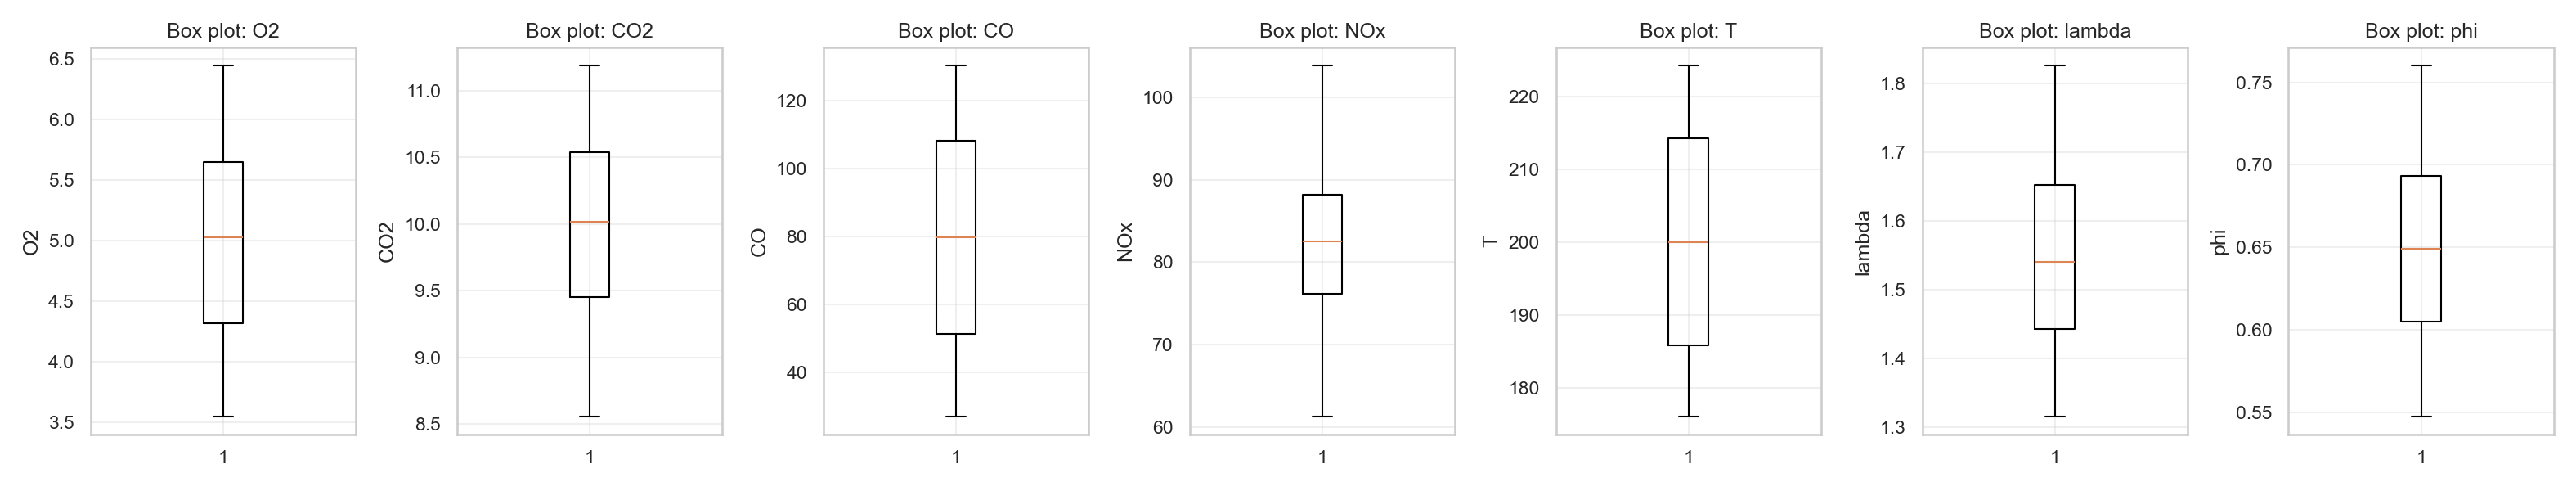

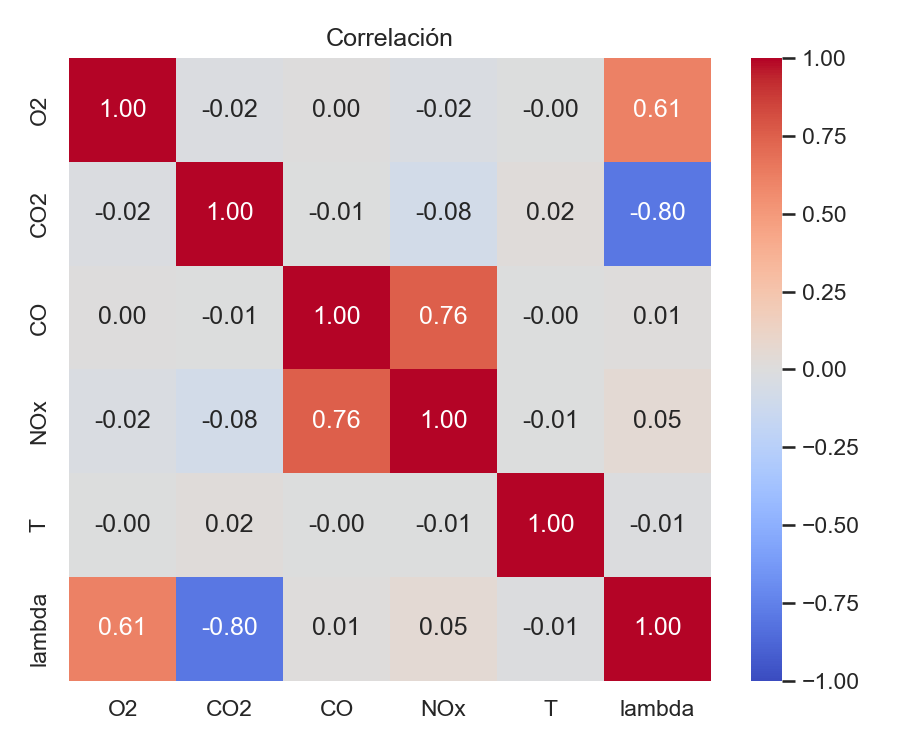

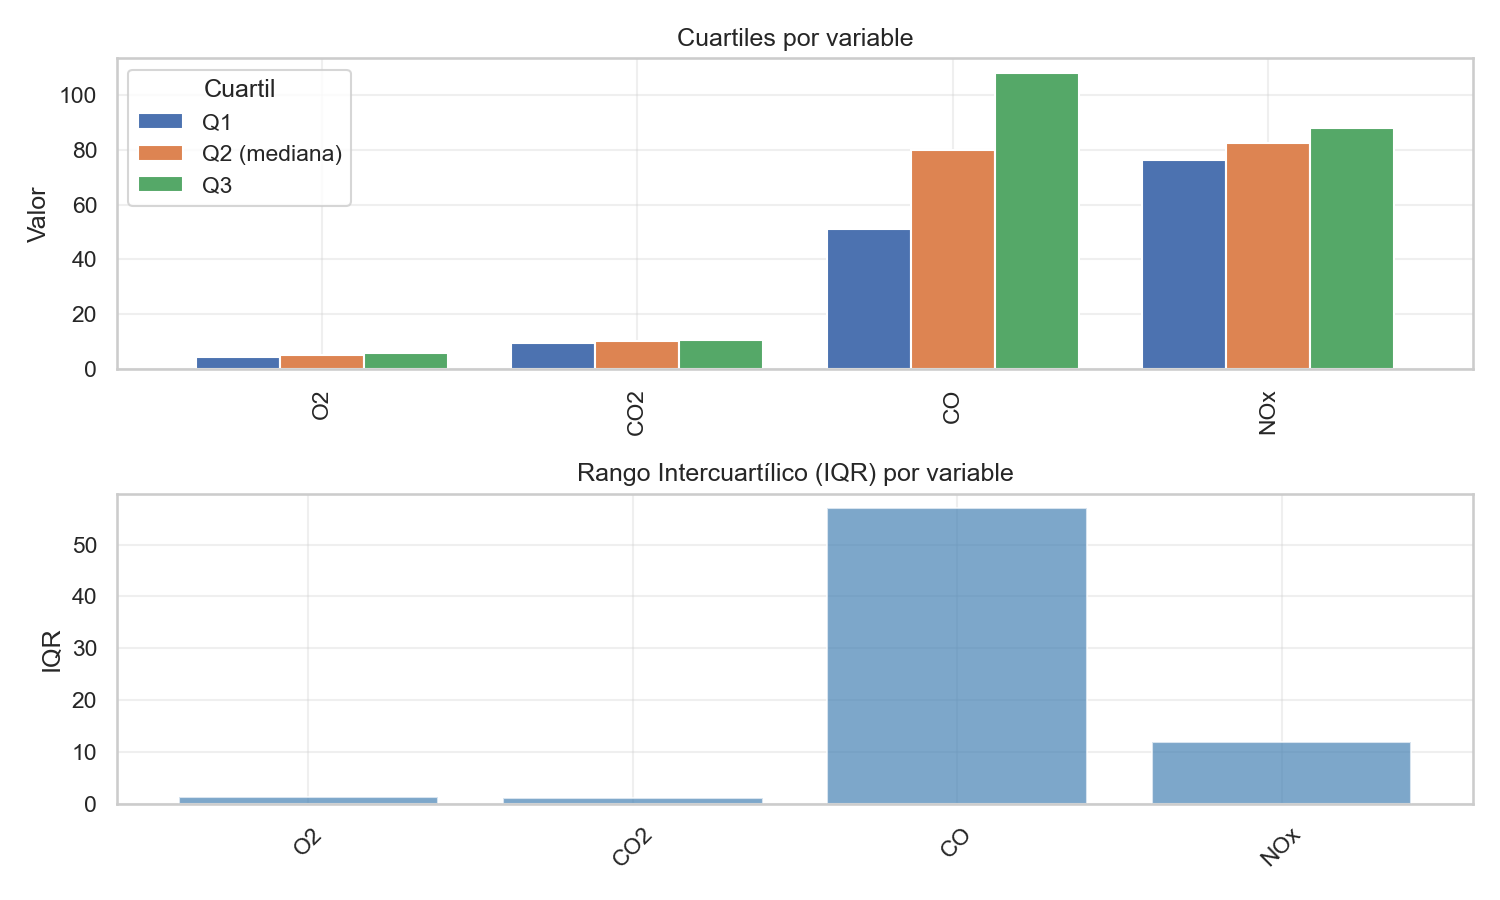

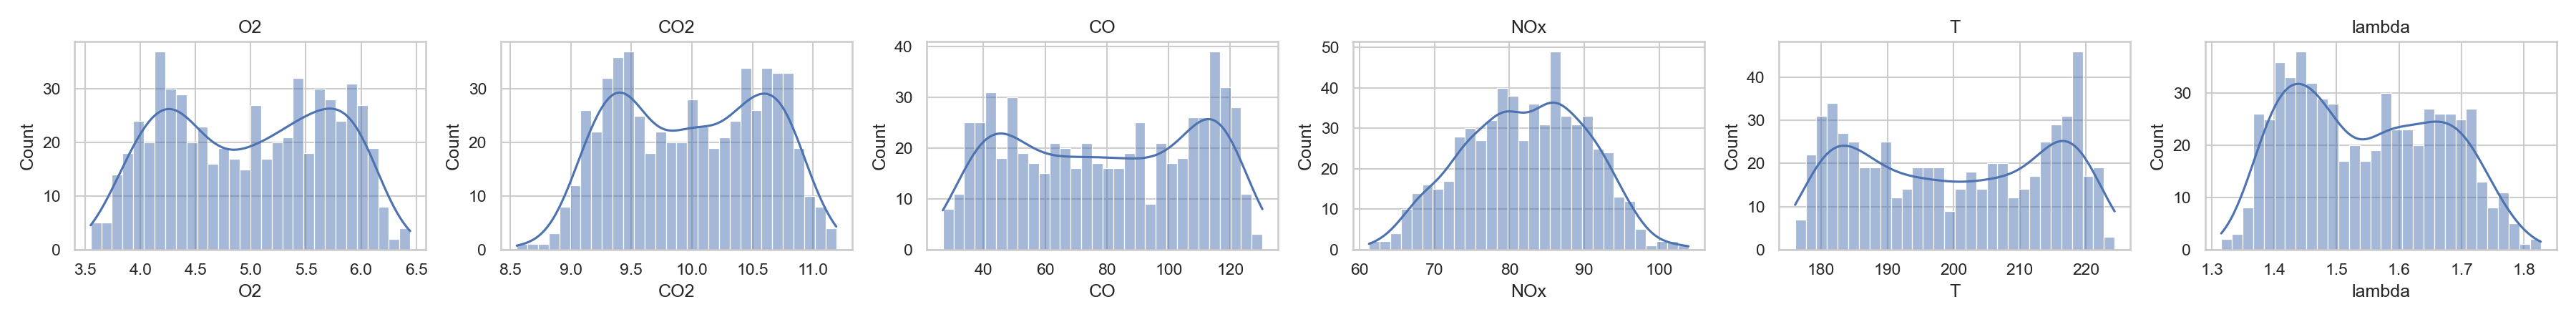

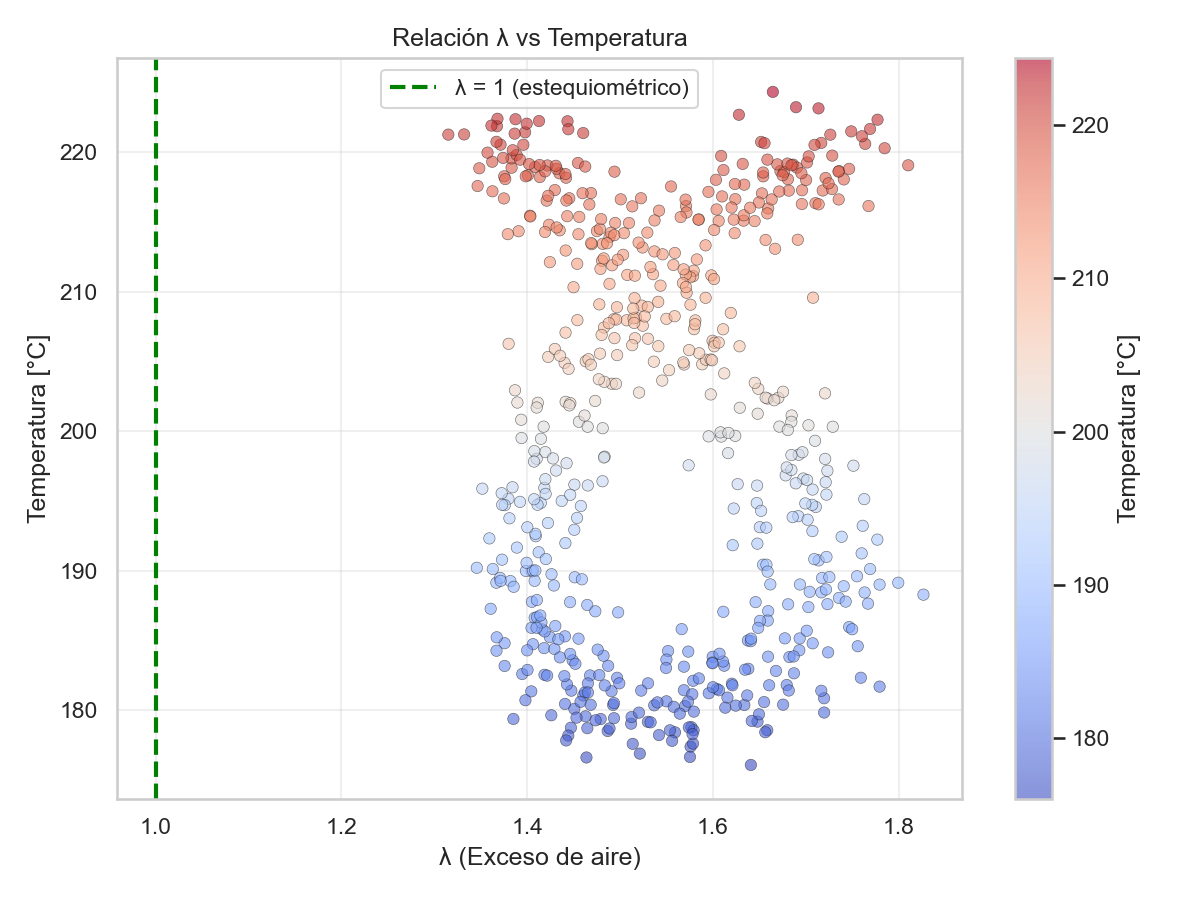

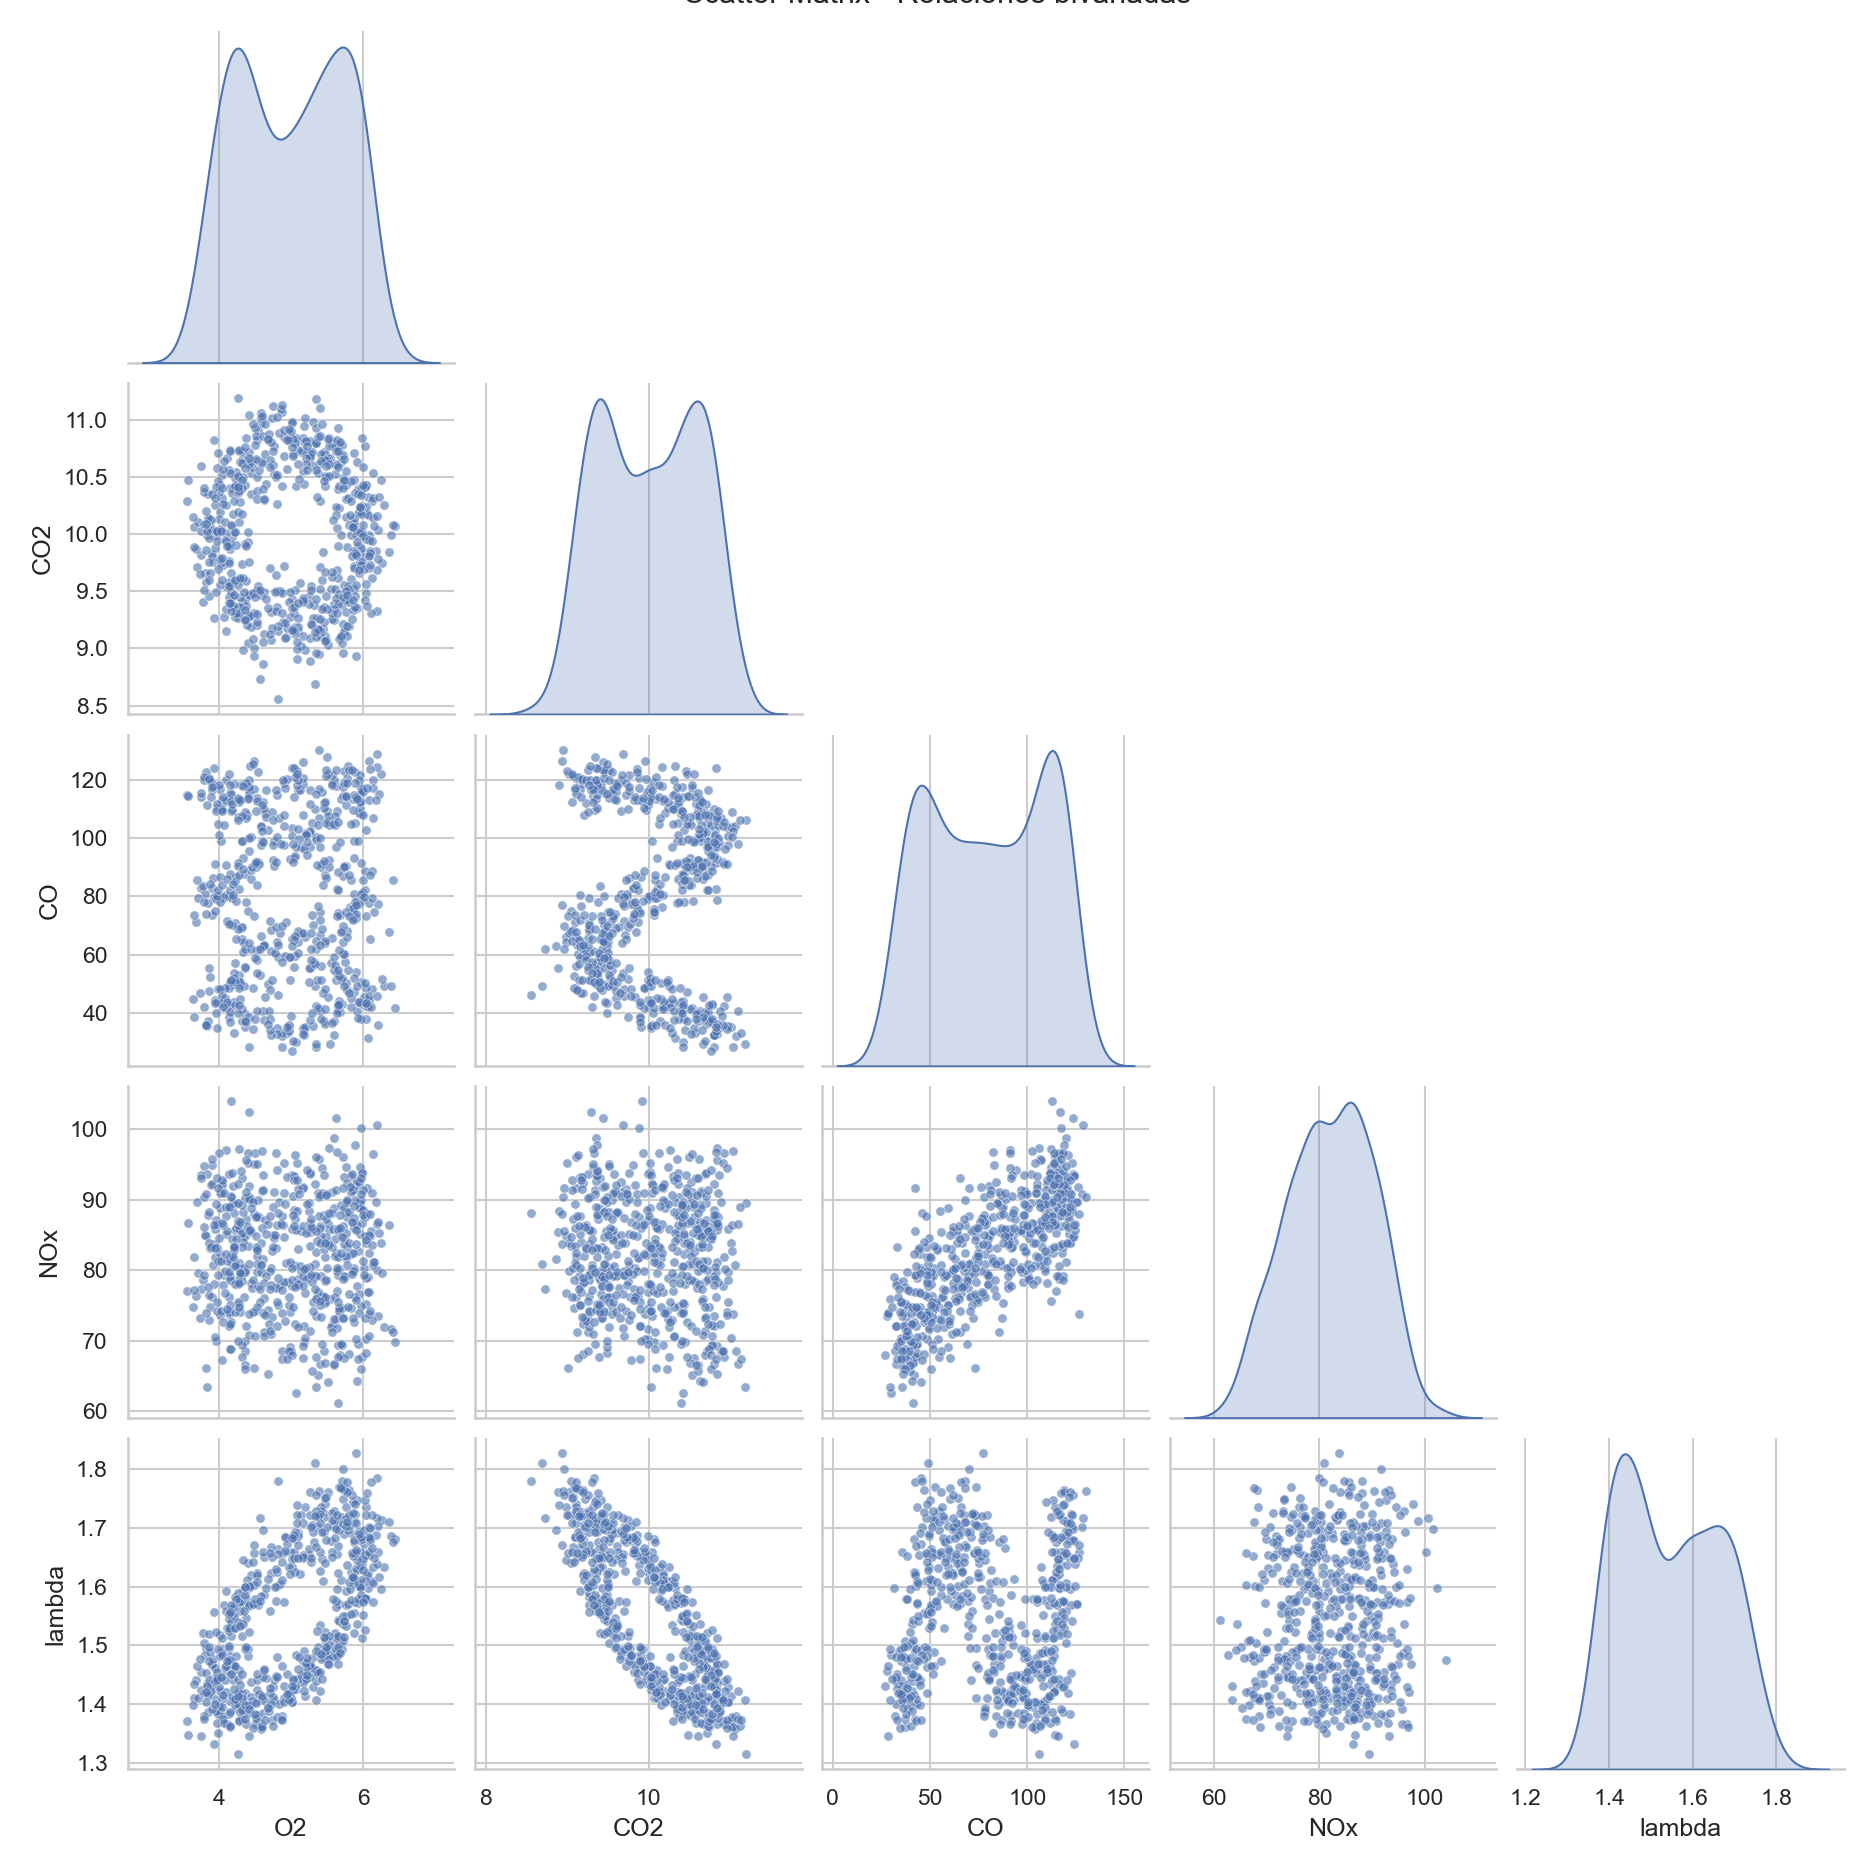

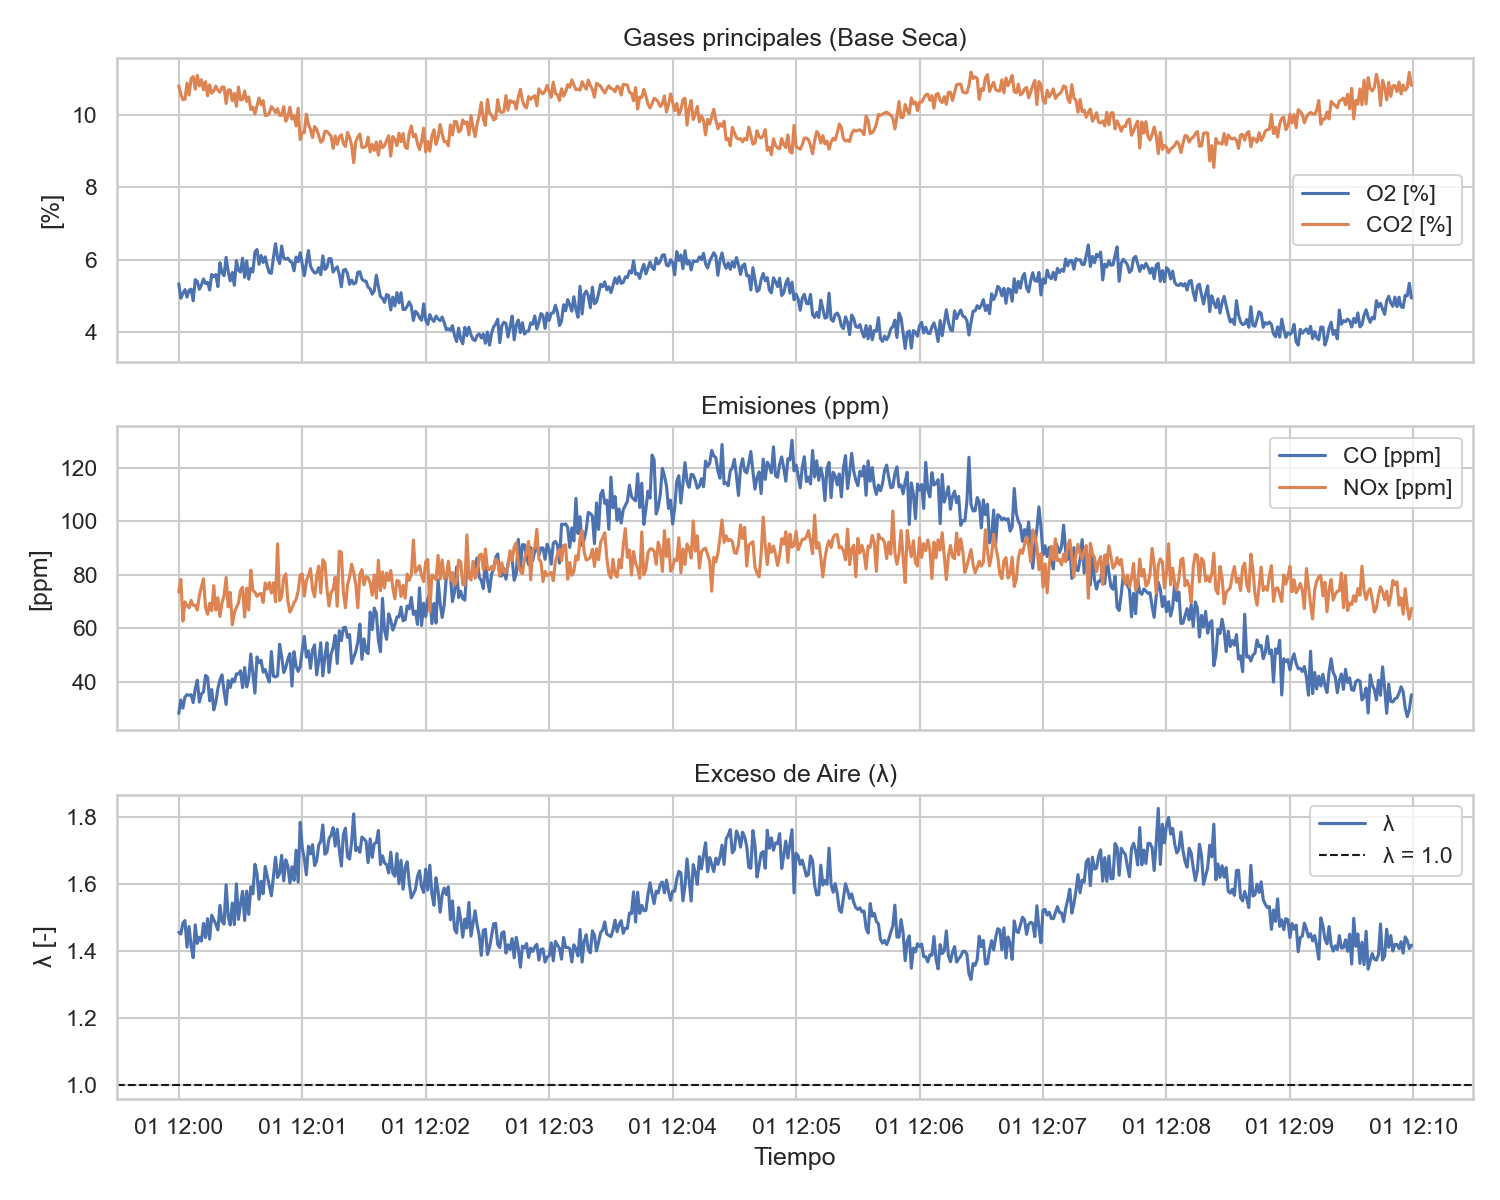

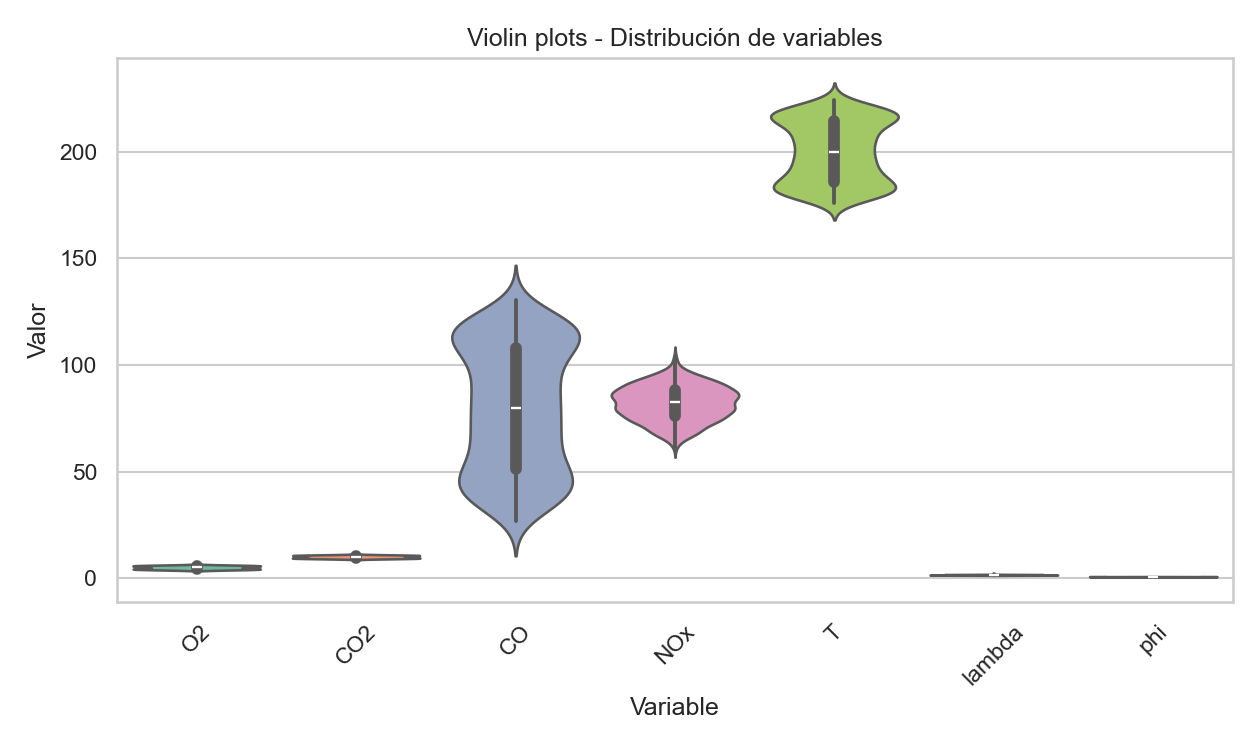

In [14]:
from combustion_utils import (
    plot_time_series, plot_hist_corr, plot_boxplots,
    plot_violin, plot_pairplot, plot_quartiles, plot_lambda_temp
)

plot_time_series(metrics)
plot_hist_corr(metrics)
plot_boxplots(metrics)
plot_violin(metrics)
plot_pairplot(metrics)
plot_quartiles(metrics)
plot_lambda_temp(metrics)

fig_dir = cu.DATA_DIR / 'figures'
imgs = sorted(glob.glob(str(fig_dir / '*.png')))
cu.print_status(f'Figuras generadas: {len(imgs)}')
for p in imgs:
    display(Image(filename=p))

## Resumen de salidas
El módulo puede generar un manifiesto JSON con la lista de archivos creados.

In [15]:
# Generar manifest si está disponible en el módulo
if 'generate_manifest' in dir(cu):
    cu.generate_manifest()
    manifest_path = cu.DATA_DIR / 'outputs_manifest.json'
    if manifest_path.exists():
        print(manifest_path)
        print(manifest_path.read_text(encoding='utf-8')[:1000] + ('...' if manifest_path.stat().st_size > 1000 else ''))
else:
    cu.print_status('generate_manifest() no disponible en este módulo.')

[2025-10-31 17:33:02] Manifest de salidas: outputs_manifest.json

Total tablas generadas: 10
Total figuras generadas: 16 (8 gráficos en PNG+SVG)
C:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P08_Productos_Combustion\data\outputs_manifest.json
{
  "tables": [
    "C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\synthetic_example_combustion.csv",
    "C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\combustion_metrics.csv",
    "C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\temperatura_adiabatica.csv",
    "C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\stats_descriptivos.csv",
    "C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\\stats_outliers_iqr.csv",
    "C:\\Users\\edgar\\Documents\\GitHub\\Aero-Messure\\Practicas\\P08_Productos_Combustion\\data\